In [1]:
from model import *
from data import *
from helpers import *

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.nn.utils.prune
import pytorch_lightning as pl
from data import *
from scipy import stats

# Enocder class
class Encoder(pl.LightningModule):
    """
    Neural network used as encoder
    """
    def __init__(self,
                 nitems: int,
                 latent_dims: int,
                 hidden_layer_size: int,
                 hidden_layer_size2: int):
        """
        Initialisation
        :param latent_dims: number of latent dimensions of the model
        """
        super(Encoder, self).__init__()

        input_layer = nitems

        self.dense1 = nn.Linear(input_layer, hidden_layer_size)
        self.dense2 = nn.Linear(hidden_layer_size, hidden_layer_size2)
        self.densem = nn.Linear(hidden_layer_size2, latent_dims)
        self.denses = nn.Linear(hidden_layer_size2, latent_dims)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        A forward pass though the encoder network
        :param x: a tensor representing a batch of response data
        :param m: a mask representing which data is missing
        :return: a sample from the latent dimensions
        """

        # calculate s and mu based on encoder weights
        out = F.elu(self.dense1(x))
        out = F.elu(self.dense2(out))
        mu =  self.densem(out)
        log_sigma = self.denses(out)

        return mu, log_sigma

# Sampling layer
class SamplingLayer(pl.LightningModule):
    def __init__(self):
        super(SamplingLayer, self).__init__()
        self.N = torch.distributions.Normal(0, 1)

    def forward(self, mu, log_sigma):
        sigma = torch.exp(log_sigma)
        error = self.N.sample(mu.shape)
        # potentially move error vector to GPU
        error = error.to(mu)
        return mu + sigma * error

# Decoder class
class Decoder(pl.LightningModule):
    """
    Neural network used as decoder
    """

    def __init__(self, nitems: int, latent_dims: int):
        """
        Initialisation
        :param latent_dims: the number of latent factors
        :param qm: IxD Q-matrix specifying which items i<I load on which dimensions d<D
        """
        super().__init__()

        # initialise netowrk components
        input_layer = latent_dims
        self.linear = nn.Linear(input_layer, nitems)
        self.activation = nn.Sigmoid()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass though the network
        :param x: tensor representing a sample from the latent dimensions
        :param m: mask representing which data is missing
        :return: tensor representing reconstructed item responses
        """
        out = self.linear(x)
        out = self.activation(out)
        return out
    
# Decoder class
class Decoder_Normal(pl.LightningModule):
    """
    Neural network used as decoder
    """

    def __init__(self, nitems: int, latent_dims: int):
        """
        Initialisation
        :param latent_dims: the number of latent factors
        :param qm: IxD Q-matrix specifying which items i<I load on which dimensions d<D
        """
        super().__init__()

        # initialise netowrk components
        input_layer = latent_dims
        self.linear = nn.Linear(input_layer, nitems)
        self.activation = nn.Sigmoid()


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass though the network
        :param x: tensor representing a sample from the latent dimensions
        :param m: mask representing which data is missing
        :return: tensor representing reconstructed item responses
        """
        out = self.linear(x)
        return out

# Entire variational autoencoder class
class VAE(pl.LightningModule):
    """
    Neural network for the entire variational autoencoder
    """
    def __init__(self,
                 dataloader,
                 nitems: int,
                 latent_dims: int,
                 hidden_layer_size: int,
                 hidden_layer_size2: int,
                 learning_rate: float,
                 batch_size: int,
                 beta: int = 1):
        """
        Initialisaiton
        :param latent_dims: number of latent dimensions
        """
        super(VAE, self).__init__()
        #self.automatic_optimization = False
        self.nitems = nitems
        self.dataloader = dataloader

        self.encoder = Encoder(nitems,
                               latent_dims,
                               hidden_layer_size,
                               hidden_layer_size2
        )

        self.sampler = SamplingLayer()

        self.decoder = Decoder(nitems, latent_dims)

        self.lr = learning_rate
        self.batch_size = batch_size
        self.beta = beta
        self.kl=0

    def forward(self, x: torch.Tensor):
        """
        forward pass though the entire network
        :param x: tensor representing response data
        :param m: mask representing which data is missing
        :return: tensor representing a reconstruction of the input response data
        """
        mu, log_sigma = self.encoder(x)
        z = self.sampler(mu, log_sigma)
        reco = self.decoder(z)

        # calcualte kl divergence
        kl = 1 + 2 * log_sigma - torch.square(mu) - torch.exp(2 * log_sigma)
        kl = torch.sum(kl, dim=-1)
        self.kl = -.5 * torch.mean(kl)
        return reco

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)

    def training_step(self, batch, batch_idx):
        # forward pass

        data, mask = batch
        X_hat = self(data)

        # calculate the likelihood, and take the mean of all non missing elements
        # bce = data * torch.log(X_hat) + (1 - data) * torch.log(1 - X_hat)
        # bce = bce*mask
        # bce = -self.nitems * torch.mean(bce, 1)
        # bce = bce / torch.mean(mask.float(),1)

        bce = torch.nn.functional.binary_cross_entropy(X_hat, batch[0], reduction='none')
        bce = torch.mean(bce)  * self.nitems
        bce = bce / torch.mean(mask.float())

        # sum the likelihood and the kl divergence

        #loss = torch.mean((bce + self.encoder.kl))
        loss = bce + self.beta * self.kl
        #self.log('binary_cross_entropy', bce)
        #self.log('kl_divergence', self.encoder.kl)
        self.log('train_loss',loss)

        return {'loss': loss}

    def train_dataloader(self):
        return self.dataloader

    def compute_information(self, theta):
        # compute conditional p(x|theta) (likelihood)
        prob = self.decoder(theta)

        # Loop though output dimensions/items, save Fisher information matrix for each
        FIMs = []
        for i in range(prob.shape[0]):
            p = prob[i]
            # compute gradients of log p(x=1) and log p(x=0) to the latent variables 
            gradient0 = torch.autograd.grad(torch.log(1-p), theta, retain_graph=True, allow_unused=True)[0]
            gradient1 = torch.autograd.grad(torch.log(p), theta, retain_graph=True, allow_unused=True)[0]

            # Compute the outer product of the gradients with itself
            outer0 = torch.outer(gradient0, gradient0)
            outer1 = torch.outer(gradient1, gradient1)

            # compute the Fisher information matrix by calculating the expectation of this outer product 
            FIM = p * outer1 + (1-p) * outer0

            # append to list of FIMs
            FIMs.append(FIM.detach().numpy())

        return FIMs


# Entire variational autoencoder class
class VAE_normal(pl.LightningModule):
    """
    Neural network for the entire variational autoencoder
    """
    def __init__(self,
                 dataloader,
                 nitems: int,
                 latent_dims: int,
                 hidden_layer_size: int,
                 hidden_layer_size2: int,
                 learning_rate: float,
                 batch_size: int,
                 beta: int = 1):
        """
        Initialisaiton
        :param latent_dims: number of latent dimensions
        """
        super(VAE_normal, self).__init__()
        #self.automatic_optimization = False
        self.nitems = nitems
        self.dataloader = dataloader

        self.encoder = Encoder(nitems,
                               latent_dims,
                               hidden_layer_size,
                               hidden_layer_size2
        )

        self.sampler = SamplingLayer()

        self.decoder = Decoder(nitems, latent_dims)

        self.lr = learning_rate
        self.batch_size = batch_size
        self.beta = beta
        self.logscale = nn.Parameter(torch.Tensor([0]))
        self.kl=0

    def forward(self, x: torch.Tensor):
        """
        forward pass though the entire network
        :param x: tensor representing response data
        :param m: mask representing which data is missing
        :return: tensor representing a reconstruction of the input response data
        """
        mu, log_sigma = self.encoder(x)
        z = self.sampler(mu, log_sigma)
        reco = self.decoder(z)

        # calcualte kl divergence
        #kl = 1 + 2 * log_sigma - torch.square(mu) - torch.exp(2 * log_sigma)
        #kl = torch.sum(kl, dim=-1)
        #self.kl = -.5 * torch.mean(kl)

        self.kl = self.kl_divergence(z, mu, torch.exp(log_sigma)).mean()
        return reco
    
    def gaussian_likelihood(self, x_hat, logscale, x):
        scale = torch.exp(logscale)
        mean = x_hat
        dist = torch.distributions.Normal(mean, scale)

        # log prob of seeing image under p(x|z)
        log_pxz = dist.log_prob(x)
        return log_pxz.sum()
    
    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, amsgrad=True)

    def training_step(self, batch, batch_idx):
        # forward pass

        data, mask = batch
        X_hat = self(data)

        # calculate the likelihood, and take the mean of all non missing elements
        # bce = data * torch.log(X_hat) + (1 - data) * torch.log(1 - X_hat)
        # bce = bce*mask
        # bce = -self.nitems * torch.mean(bce, 1)
        # bce = bce / torch.mean(mask.float(),1)

        ll = self.gaussian_likelihood(X_hat, self.logscale, data)

        # sum the likelihood and the kl divergence

        #loss = torch.mean((bce + self.encoder.kl))
        loss = -ll + self.beta * self.kl
        #self.log('binary_cross_entropy', bce)
        #self.log('kl_divergence', self.encoder.kl)
        self.log('train_loss',loss)

        return {'loss': loss}

    def train_dataloader(self):
        return self.dataloader

    def compute_information(self, theta):
        # compute predicted mu for each output dimension
        mu = self.decoder(theta)
        
        # Get the number of dimensions/items
        output_dimensions = mu.shape[0]
        
        # Calculate Hermite polynomial roots and weights for integration
        n = 10  
        roots, weights = roots_hermite(n)
        roots = torch.Tensor(roots)
        weights = torch.Tensor(weights)
        
        # Initialize the Fisher information matrix
        FIMs = [torch.zeros((len(theta), len(theta))) for _ in range(num_dimensions)]
        
        # Loop through output dimensions (items)
        for d in range(num_dimensions):
            # loop though quadrature points
            for i in range(len(roots)):
                # create normal distribution centered at the predicted mu for this item
                N = torch.distributions.Normal(mu[d], torch.exp(self.logscale))
                # calculate the log likelihood of the root under this prediction
                log_prob = N.log_prob(roots[i])
                # calculate the gradient of this probability with respect to theta
                gradient = torch.autograd.grad(log_prob, theta, create_graph=True)[0]
                
                # Calculate the outer product of the gradient
                outer = torch.outer(gradient, gradient)
                
                # Update the Fisher information matrix for this dimension, weighing by the GH weights
                FIMs[d] += outer * weights[i]
        
        return FIMs
            



## Simulation data and fit mdel

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from torch.utils.data import DataLoader, Dataset
import sys
import time
import os
from model import *
# set working directory to source file location
#abspath = os.path.abspath(__file__)
#dname = os.path.dirname(abspath)
#os.chdir(dname)

# set device to gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load configurations
with open("./config.yml", "r") as f:
    cfg = yaml.safe_load(f)
    cfg = cfg['configs']



theta=np.random.normal(0,1,cfg['N']*cfg['mirt_dim']).reshape((cfg['N'], cfg['mirt_dim']))
a = np.random.uniform(.5, 2, cfg['nitems'] * cfg['mirt_dim']).reshape((cfg['nitems'], cfg['mirt_dim']))  # draw discrimination parameters from uniform distribution
b = np.linspace(-2, 2, cfg['nitems'], endpoint=True)  # eqally spaced values between -2 and 2 for the difficulty
exponent = np.dot(theta, a.T) + b
prob = np.exp(exponent) / (1 + np.exp(exponent))
data = np.random.binomial(1, prob).astype(float)

# introduce missingness
#np.random.seed(cfg['iteration'])
indices = np.random.choice(data.shape[0]*data.shape[1], replace=False, size=int(data.shape[0]*data.shape[1]*cfg['missing_percentage']))
data[np.unravel_index(indices, data.shape)] = float('nan')
data = torch.Tensor(data)

# initialise model and optimizer
logger = CSVLogger("logs", name='simfit', version=0)
trainer = Trainer(fast_dev_run=cfg['single_epoch_test_run'],
                  max_epochs=1500,#cfg['max_epochs'],
                  enable_checkpointing=False,
                  logger=False,
                  callbacks=[EarlyStopping(monitor='train_loss', min_delta=cfg['min_delta'], patience=cfg['patience'], mode='min')])

dataset = SimDataset(data)
train_loader = DataLoader(dataset, batch_size=cfg['batch_size'], shuffle=False)
vae = VAE(nitems=data.shape[1],
            dataloader=train_loader,
            latent_dims=cfg['mirt_dim'],
            hidden_layer_size=cfg['hidden_layer_size'],
            hidden_layer_size2=cfg['hidden_layer_size2'],
            learning_rate=cfg['learning_rate'],
            batch_size=cfg['batch_size'],
            n_samples=cfg['n_iw_samples']
)


start = time.time()
trainer.fit(vae)
runtime = time.time()-start

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type               | Params
-----------------------------------------------
0 | encoder | ConditionalEncoder | 6.1 K 
1 | sampler | SamplingLayer      | 0     
2 | decoder | Decoder            | 200   
-----------------------------------------------
6.3 K     Trainable params
0         Non-trainable params
6.3 K     Total params
0.025     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

In [8]:
a_est = vae.decoder.linear.weight.detach().numpy()
d_est = vae.decoder.linear.bias.t().detach().numpy()
dataset = SimDataset(data, device)
train_loader = DataLoader(dataset, batch_size=data.shape[0], shuffle=False)
data, mask = next(iter(train_loader))
theta_est, log_sigma_est = vae.encoder(data, mask)
theta_est = theta_est.detach().numpy()

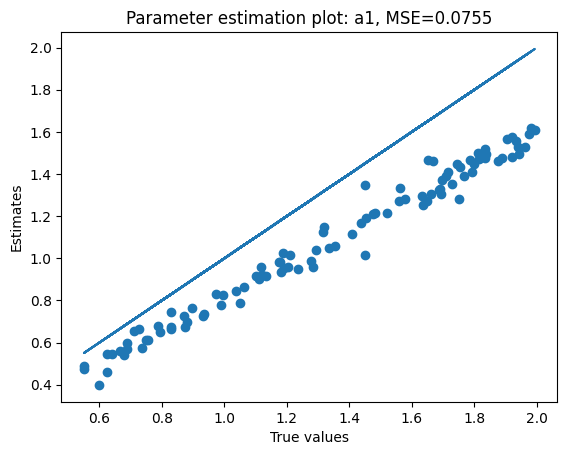

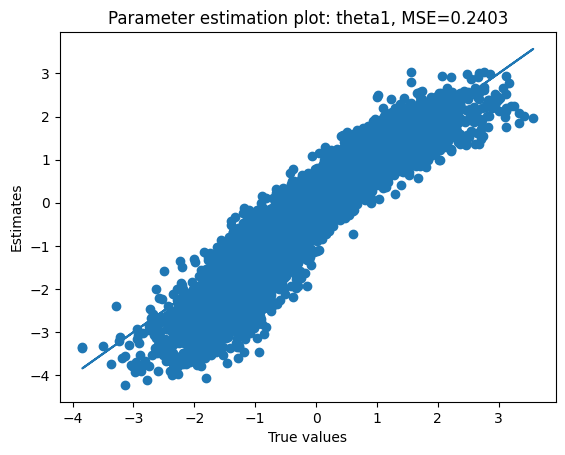

In [9]:
for dim in range(cfg['mirt_dim']):
    plt.figure()

    ai_est = a_est[:,dim]
    ai_true = a[:,dim]

    mse = MSE(ai_est, ai_true)
    plt.scatter(y=ai_est, x=ai_true)
    plt.plot(ai_true, ai_true)
    #for i, x in enumerate(ai_true):
    #    plt.text(ai_true[i], ai_est[i], i)
    plt.title(f'Parameter estimation plot: a{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')


    # parameter estimation plot for theta
    plt.figure()
    thetai_est = theta_est[:, dim]
    thetai_true = theta[:, dim]
    mse = MSE(thetai_est, thetai_true)
    plt.scatter(y=thetai_est, x=thetai_true)
    plt.plot(thetai_true, thetai_true)
    plt.title(f'Parameter estimation plot: theta{dim+1}, MSE={round(mse,4)}')
    plt.xlabel('True values')
    plt.ylabel('Estimates')


## Simulation study for new participants

In [10]:
from helpers import *
from tqdm import tqdm

def predict_mirt(a, d, theta):
    print(theta.shape)
    prob = torch.exp(a@theta.T+d) / (1 + torch.exp(a@theta.T+d))
    return prob.T

def simulate_cat(true_model, n_pers, true_theta, method, exp=0, decay=0):

    # simualte true ability values
    n_item = true_model.nitems
    mirt_dim = true_model.encoder.densem.out_features
    theta = torch.normal(torch.zeros((n_pers, mirt_dim)), torch.ones((n_pers, mirt_dim)))
    a = true_model.decoder.linear.weight.detach()
    d = true_model.decoder.linear.bias.detach().unsqueeze(1)
    # sample responses given true model
    true_prob = predict_mirt(a, d, theta)
    data = torch.bernoulli(true_prob)
    
    error_mat_theta = np.empty((n_pers, n_item))
    prob_mat = np.empty((n_pers, n_item))
    
    for p in tqdm(range(n_pers), position=0, leave=True):
        theta_est = torch.zeros(mirt_dim)
        theta_est.requires_grad = True
        theta_estimates = np.empty((n_item, mirt_dim))
        answered = np.zeros(n_item, dtype=bool)
        
        
        for i in range(n_item):
            # compute item information matrices with respect to current theta estimate
            FIMs = true_model.compute_information(theta_est)
            # compute current test information matrix
            TIM = np.zeros_like(FIMs[0])
            for m in range(len(FIMs)):
                if answered[i]:
                    TIM += FIMs[m]
            
            if method == 'det':
                dets = np.array([np.linalg.det(TIM+FIM) for FIM in FIMs])
                dets[answered] = -np.Inf
                next_item_ix =np.argmax(dets)
            if method == 'prob':
                probs = vae.decoder(theta_est).detach().numpy()
                probs[answered] = 0
                next_item_ix =np.argmax(probs)
            if method == 'mixed':
                dets = np.array([np.linalg.det(TIM+FIM) for FIM in FIMs])
                probs = vae.decoder(theta_est).detach().numpy()
                dets_z = stats.zscore(dets)
                probs_z = stats.zscore(probs)

                criterium = dets_z * exp + probs_z * (1-exp)
                criterium[answered] = -np.Inf
                next_item_ix = np.argmax(criterium)
                exp -= decay
                exp = max(0, exp)
            
            answered[next_item_ix] = True
            # 
            prob_mat[p, i] = true_prob[p, next_item_ix]
            resp_patt = data[p, ].clone().detach()
            resp_patt[~answered] = 0

            dat = torch.Tensor(resp_patt).unsqueeze(0)
            mask = (~torch.isnan(dat)).float()
  
            theta_est, _ = true_model.encoder(dat, mask)
            theta_est = theta_est[0]
            

            error_mat_theta[p, i] = MSE(theta_est.detach().numpy(), true_theta[p, ]) 
    
    return prob_mat, error_mat_theta


In [18]:
pm_p , emt_p = simulate_cat(vae, 1000, theta, 'mixed', exp=0, decay=.0)

torch.Size([1000, 1])


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [52:36<00:00,  3.16s/it]


In [19]:
pm_d , emt_d = simulate_cat(vae, 1000, theta, 'mixed', exp=1, decay=.025)

torch.Size([1000, 1])


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [54:03<00:00,  3.24s/it]


In [20]:
pm_e , emt_e = simulate_cat(vae, 1000, theta, 'mixed', exp=1, decay=0)

torch.Size([1000, 1])


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [53:14<00:00,  3.19s/it]


plt.plot(np.arange(emt_d.shape[1]), emt_d.mean(0), label='determinant')
plt.plot(np.arange(emt_p.shape[1]), emt_p.mean(0), label='probability')
plt.legend()
plt.show()

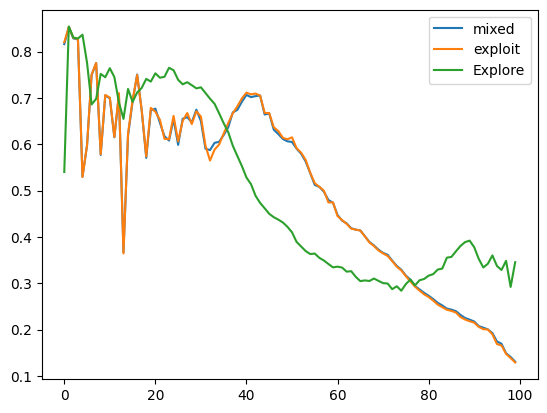

In [21]:
plt.plot(np.arange(pm_d.shape[1]), pm_d.mean(0), label='mixed')
plt.plot(np.arange(pm_p.shape[1]), pm_p.mean(0), label='exploit')
plt.plot(np.arange(pm_e.shape[1]), pm_e.mean(0), label='Explore')
plt.legend()
plt.show()

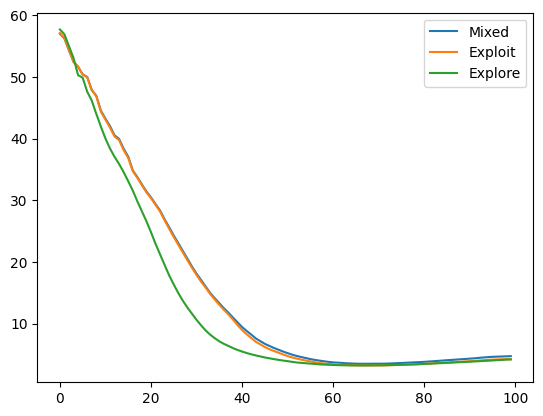

In [22]:
plt.plot(np.arange(pm_d.shape[1]), emt_d.mean(0), label='Mixed')
plt.plot(np.arange(pm_p.shape[1]), emt_p.mean(0), label='Exploit')
plt.plot(np.arange(pm_e.shape[1]), emt_e.mean(0), label='Explore')
plt.legend()
plt.show()